# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import algorithms.bernstein_vazirani as bv
import algorithms.qft as qft

from qiskit import QuantumCircuit, transpile, Aer
from qiskit_ibm_provider import IBMProvider
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info.analysis import hellinger_fidelity
from qiskit.dagcircuit.dagcircuit import DAGCircuit, DAGOpNode
from qiskit.converters import circuit_to_dag


from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit, IBMQBackend

In [2]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_guadalupe")

# Load Pickle

In [3]:
import pickle

qcs, transpiled_qcs, min_qubits, max_qubits, algorithms, techniques_temp = pickle.load( open( "save_transpile_{}.pickle".format(backend.name), "rb" ) )

In [4]:
techniques = list(techniques_temp)
techniques.insert(0, 'Tket')
techniques = tuple(techniques)
display(techniques)
del techniques_temp

('Tket', 'Qiskit Opt 0', 'Qiskit Opt 3', 'Qiskit Opt 3 Sabre')

# Run on IBM QC

In [5]:
# job = backend.run(transpiled_qcs, shots=4000)
# job = fake_backend.run(tqcs, shots=1000)

# Checkpoint

In [6]:
job = provider.backend.jobs()[1]
display(job.job_id())

'cfree93mcdu9d5vi0on0'

## Simulate QCs

In [7]:
def simulate_classically(qc_list):
    aer_sim = Aer.get_backend('aer_simulator')
    tqc_list = transpile(qc_list, aer_sim)
    job_sim = aer_sim.run(tqc_list, shots=1000)
    results = job_sim.result()
    return results

In [8]:
sim_res_counts = simulate_classically(qcs).get_counts()

## Calculate Runtimes

In [9]:
props = backend.properties()

In [10]:
def circuit_runtime_in_ms(tqc, backend):
    dag = circuit_to_dag(tqc)
    circuit_execution_time = 0
    for s in dag.layers():
        graph: DAGCircuit = s['graph']
        gate: DAGOpNode
        max_gate_time_in_layer = 0
        for gate in graph.gate_nodes():
            q_index = [qarg.index for qarg in gate.qargs]
            g_time = props.gate_length(gate.name, q_index)
            if g_time > max_gate_time_in_layer:
                max_gate_time_in_layer = g_time
        circuit_execution_time += max_gate_time_in_layer
    return circuit_execution_time*1000

In [11]:
circuit_run_times_in_ms = []

for tqc in job.circuits():
    circuit_run_times_in_ms.append(circuit_runtime_in_ms(tqc, backend))

C:\Users\thspr\AppData\Local\Temp\ipykernel_19296\2378081819.py:9: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q_index = [qarg.index for qarg in gate.qargs]


In [12]:
len(circuit_run_times_in_ms)

88

In [13]:
def calculate_avg_cx_errors(backend):
    cx_gates = [g for g in backend.properties().gates if g.gate == 'cx']
    cx_error_rate = 0
    for g in cx_gates:    
        cx_error_rate += g.parameters[0].value

    avg_cx_error_rate = cx_error_rate /len(cx_gates)
    return avg_cx_error_rate

In [14]:
avg_cx_error_rate = calculate_avg_cx_errors(backend)
print('avg_cx_error_rate: ', avg_cx_error_rate)

avg_cx_error_rate:  0.009059585673196945


In [15]:
qc_res_counts = job.result().get_counts()

In [16]:
cx_counts = []
for tqc in job.circuits():
    cx_counts.append(tqc.count_ops()['cx'])

# Calculate Fidelities

In [19]:
fidelities = []
n_s = max_qubits-min_qubits+1

for al_index, al_name in enumerate(algorithms):
    for n_index in range(n_s):
        n = n_index + min_qubits
        sim_res_counts_n = sim_res_counts[al_index*(n_s) + n_index]
        for t_index, t_name in enumerate(techniques):
            tqc_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
            qc_counts = qc_res_counts[tqc_index]
            hf = hellinger_fidelity(sim_res_counts_n, qc_counts)
            fidelities.append(hf)

# Results

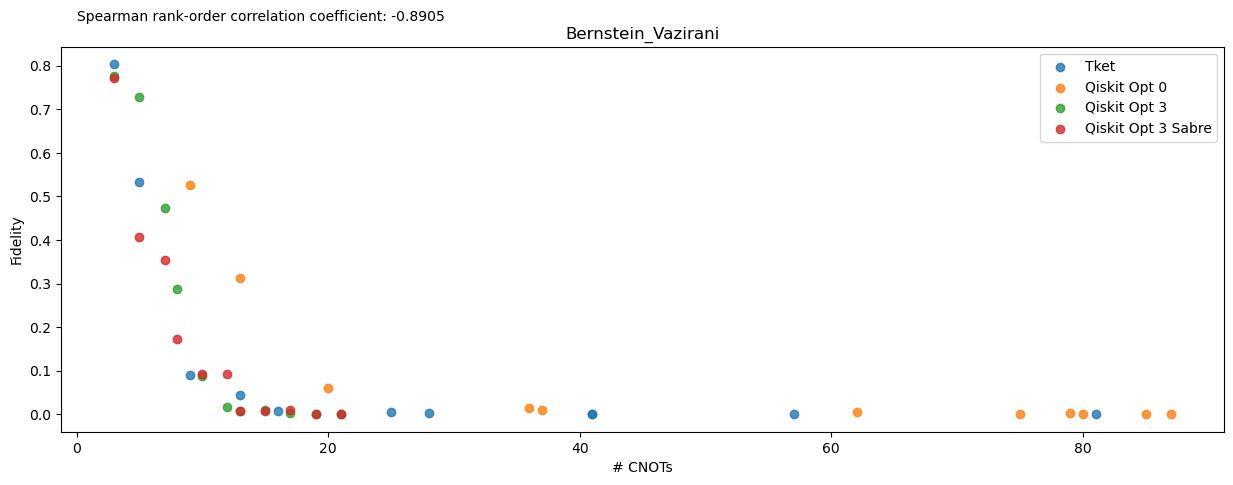

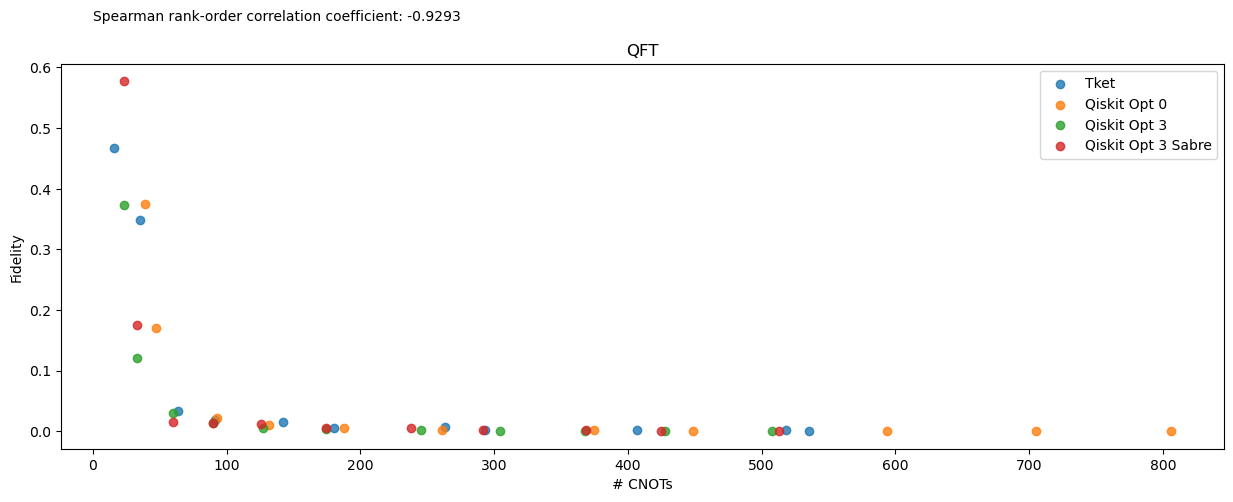

In [30]:
# fidelity vs no of cnots


for al_index, al_name in enumerate(algorithms):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set(xlabel='# CNOTs', ylabel='Fidelity', title=al_name)
    x2 = []
    y2 = []
    for t_index, t_name in enumerate(techniques):
        x = []
        y = []
        for n_index in range(n_s):
            tqc_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
            x.append(cx_counts[tqc_index])
            y.append(fidelities[tqc_index])
        ax.scatter(x, y, label = t_name, alpha=0.8)
        ax.legend()
        x2.extend(x)
        y2.extend(y)
    res = stats.spearmanr(x2, y2)
    ax.text(0, max(y2)+0.1, 'Spearman rank-order correlation coefficient: {:2.4f}'.format(res.statistic))
    plt.show(fig)

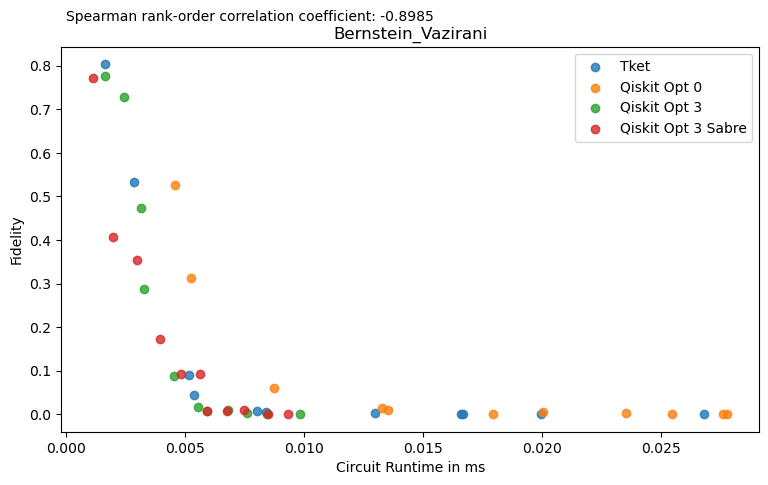

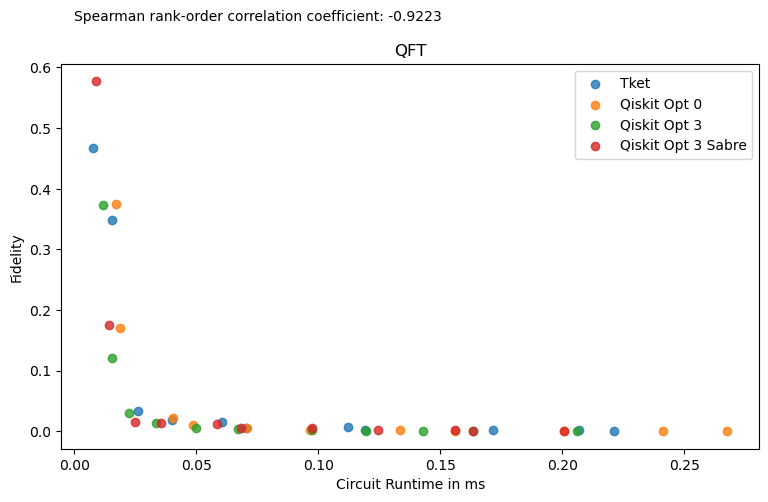

In [29]:
# fidelity vs no of runtime


for al_index, al_name in enumerate(algorithms):
    fig, ax = plt.subplots(figsize=(9,5))
    ax.set(xlabel='Circuit Runtime in ms', ylabel='Fidelity', title=al_name)
    x2 = []
    y2 = []
    for t_index, t_name in enumerate(techniques):
        x = []
        y = []
        for n_index in range(n_s):
            tqc_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
            x.append(circuit_run_times_in_ms[tqc_index])
            y.append(fidelities[tqc_index])
        ax.scatter(x, y, label = t_name, alpha=0.8)
        ax.legend()
        x2.extend(x)
        y2.extend(y)
    res = stats.spearmanr(x2, y2)
    ax.text(0, max(y2)+0.1, 'Spearman rank-order correlation coefficient: {:2.4f}'.format(res.statistic))
    plt.show(fig)

# Test

In [ ]:
# res = stats.spearmanr(fidelities, cx_counts)
# print(res.statistic)

In [ ]:
# res = stats.spearmanr(fidelities, cx_counts)
# print(res.statistic)

In [ ]:
# for al_index, al_name in enumerate(algorithms.keys()):
#     for n_index in range(n_s):
#         n = n_index + min_qubits
#         print('{}: n={}'.format(al_name, n))
#         sim_res_counts_n = sim_res_counts[al_index*(n_s) + n_index]
#         for t_index, t_name in enumerate(techniques.keys()):
#             tqc_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
#             qc_counts = qc_res_counts[tqc_index]
#             cx_count = cx_counts[tqc_index]
#             run_time = circuit_run_times[tqc_index]
#             hf = fidelities[tqc_index]
#             print('{}: # cx gates={}, run_time={}, fidelity={}'.format(t_name, cx_count, run_time, hf))
#         print('---')
#     print('------')
            